## Switching Linear Dynamical System Demo

_Switching Linear Dynamical Systems_ (SLDS) provide a natural way of combining Linear Dynamical Systems with Hidden Markov Models. They allow us to approximate a system that has globally non-linear dynamics by a series linear systems. A good reference for these types of systems is ["Variational Inference for State Space models"](https://www.cs.toronto.edu/~hinton/absps/switch.pdf) by Ghahramani and Hinton. 

An LDS comprises $K$ discrete hidden states, which evolve according to a Markov chain. We'll call the hidden state $z$, and use the notation $z_t = k$ to mean that the system is in state $k$ at time $t$. The Markov chain for the hidden state is specified by a state-transition matrix $Q$, where $Q_{ij} = P(z_t = j \mid z_{t-1} = i)$.

### Generative Model for SLDS
The generative model for an SLDS combines an HMM with a set of linear dynamical systems as follows. In addition to the discrete state, we have a continuous latent state $x_t \in \mathbb{R}^D$ and an observation $y_t \in \mathbb{R}^N$. Each discrete state $\{1,\ldots,K
\}$ is associated with a different dynamics matrix $A_k$ and a different measurement matrix $C_k$. Formally, we generate data from an SLDS as follows:

1. **Discrete State Update**. At each time step, sample a new discrete state $z_t \mid z_{t-1}$ with probabilities given by a Markov chain.

2. **Continuous State Update**. Update the state using the dynamics matrix corresponding to the new discrete state:
$$
x_t = A_k x_{t-1} + V_k u_{t} + b_k + w_t
$$
$A_k$ is the dynamics matrix corresponding to discrete state $k$. $u_t$ is the input vector (specified by the user, not inferred by SSM) and $V_k$ is the corresponding control matrix. The vector $b$ is an offset vector, which can drive the dynamics in a particular direction. 
The terms $w_t$ is a noise terms, which perturbs the dynamics. 
Most commonly these are modeled as zero-mean multivariate Gaussians,
but one nice feature of SSM is that it supports many distributions for these noise terms. See the Linear Dynamical Systems notebook for a list of supported dynamics models.

3. **Emission**. We now make an observation of the state, according to the specified observation model. In the general case, the state controlls the observation via a Generalized Linear Model:
$$
y_t \sim \mathcal{P}(\eta(C_k x_t + d_k + F_k u_t + v_t))
$$
$\mathcal{P}$ is a probabibility distribution. The inner arguments form an affine measurement of the state, which is then passed through the inverse link function $\eta(\cdot)$.
In this case, $C_k$ is the measurement matrix corresponding to discrete state $k$, $d_k$ is an offset or bias term corresponding to discrete state $k$, $F_k$ is called the feedthrough matrix or passthrough matrix (it passes the input directly to the emission). In the Gaussian case, the emission can simply be written as $y_t = C_k x_t + d_k + F_k u_t + v_t$ where $v_t$ is a Gaussian r.v. See the Linear Dynamical System notebook for a list of the observation models supported by SSM.
  



## 1. Setup
We import SSM as well as a few other utilities for plotting.

In [ ]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d

save_figures = False

## 2. Creating an SLDS and Sampling
Below, we set some parameters for our SLDS: 5 discrete states, latent state of dimension 2, emissions of dimensions 10. We'll be sampling for 100 time bins for the purpose of visualizing the output of our SLDS.

We then create an SLDS object:
```python
true_slds = ssm.SLDS(emissions_dim,
                     n_disc_states,
                     latent_dim,
                     emissions="gaussian_orthog")
```
We specify the emissions model as `"gaussian_orthog"` which ensures that each measurement matrix $C_k$ will be orthogonal. Because an orthogonal matrix is full-rank, this means that our system is fully observable. In other words, the emissions model does not "losing" information about the state.

The syntax for sampling from an SLDS is the same as for an LDS:
```python
states_z, states_x, emissions = true_lds.sample(time_bins)
```
The sample function for SLDS returns a tuple of (discrete states, continuous states, observations).


In [1]:
# Set the parameters of the SLDS
time_bins = 100    # number of time bins
n_disc_states = 5       # number of discrete states
latent_dim = 2       # number of latent dimensions
emissions_dim = 10      # number of observed dimensions

In [2]:
# Make an SLDS with the true parameters
true_slds = ssm.SLDS(emissions_dim,
                     n_disc_states,
                     latent_dim,
                     emissions="gaussian_orthog")

for k in range(n_disc_states):
    true_slds.dynamics.As[k] = .95 * random_rotation(latent_dim, theta=(k+1) * np.pi/20)
    
states_z, states_x, emissions = true_slds.sample(time_bins)
print(f"States_z: {states_z}")
print(f"\nStates_x: {states_x}")
print(f"\nemissions: {emissions}")

States_z: [1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 2 2 2 2 0 0 0 4 4 1 1 1 1 1 2 3 3 3 3 3 3 3 3 4 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 0 0 0 2 3 3 3 3 3 3 3 3 3 3 2 2 2]

States_x: [[ -1.7493151    0.25853528]
 [ -1.4510424    1.35263396]
 [ -1.19795903   2.24172653]
 [ -0.53335317   2.93335913]
 [  0.637308     3.62829951]
 [  1.84279633   3.90918675]
 [  3.77460343   4.43026014]
 [  3.22915583   2.25905687]
 [  5.59949808   1.98140148]
 [  3.88402834  -0.23895515]
 [  3.14370599  -0.79006441]
 [  2.72888894  -0.30083694]
 [  3.18767346  -0.16898439]
 [  1.30454592  -1.68342042]
 [ -2.00367698  -0.89783853]
 [ -2.18733943   1.49984225]
 [ -0.78711159   4.01059373]
 [  1.06961537   4.73421582]
 [  2.18759506   4.53742024]
 [  4.47653047   3.64727458]
 [  8.0867714    1.56144294]
 [  5.05058235  -1.76348916]
 [  2.40126801  -2.79822765]
 [  3.70719468  -1.57651315]
 [  0.17468784  -2.48793334]
 [  0.42870633   0.0318821 ]
 [ -1.27944837   0.63

### 2.1 Visualize the Latent States
Below, we visualize the 2-dimensional trajectory of the continuous latent state $x_t$. The different colors correspond to different values of the discrete state variable $z_t$. We can see how the different colors correspond to different dynamics on the latent state.

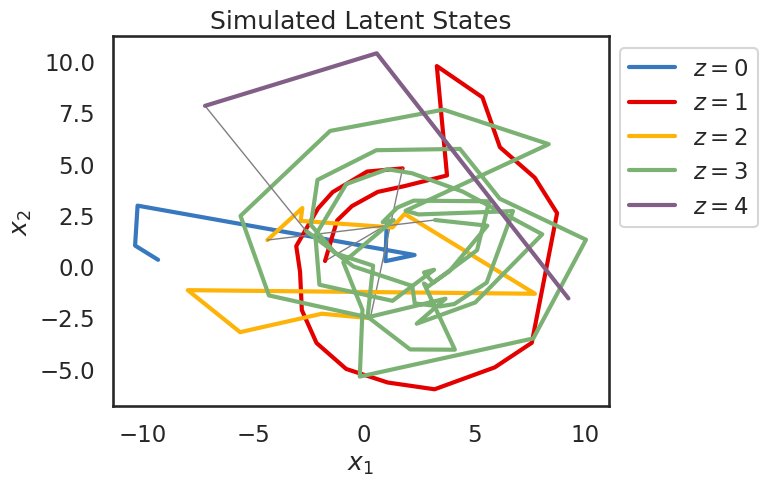

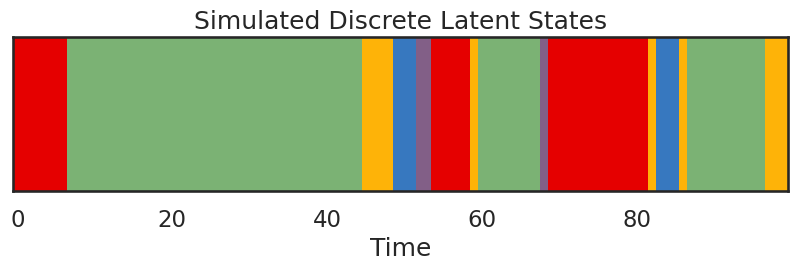

In [3]:
for k in range(n_disc_states):
    curr_states = states_x[states_z == k]
    plt.plot(curr_states[:,0],
             curr_states[:,1],
             '-',
             color=colors[k],
             lw=3,
             label="$z=%i$" % k)
    
    # Draw lines connecting the latent state between discrete state transitions,
    # so they don't show up as broken lines.
    next_states = states_x[states_z == k+1]
    if len(next_states) > 0 and len(curr_states) > 0:
        plt.plot((curr_states[-1,0], next_states[0,0]),
                 (curr_states[-1,1], next_states[0,1]),
                 '-',
                 color='gray',
                 lw=1)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

plt.figure(figsize=(10,2))
cmap_limited = ListedColormap(colors[0:n_disc_states])
plt.imshow(states_z[None,:],  aspect="auto", cmap=cmap_limited)
plt.title("Simulated Discrete Latent States")
plt.yticks([])
plt.xlabel("Time")
plt.show()

### 2.1 Visualize the Emissions
Below, we visualize the 10-dimensional emissions from our SLDS.

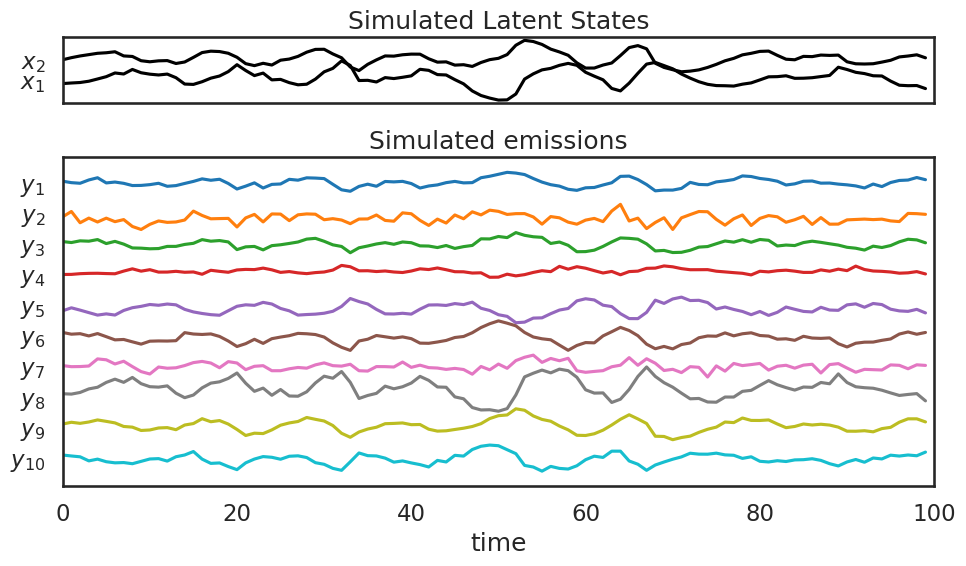

In [4]:
plt.figure(figsize=(10, 6))
gs = plt.GridSpec(2, 1, height_ratios=(1, emissions_dim/latent_dim))

# Plot the continuous latent states
lim = abs(states_x).max()
plt.subplot(gs[0])
for d in range(latent_dim):
    plt.plot(states_x[:, d] + lim * d, '-k')
plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Simulated Latent States")

lim = abs(emissions).max()
plt.subplot(gs[1])
for n in range(emissions_dim):
    plt.plot(emissions[:, n] - lim * n, '-')
plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
plt.xlabel("time")
plt.xlim(0, time_bins)

plt.title("Simulated emissions")
plt.tight_layout()

if save_figures:
    plt.savefig("lds_2.pdf")

## 3. Fit an SLDS From Data
SSM provides the capability to learn the parameters of an SLDS from data. In the above cells, we sampled from 100 time-steps in order to visualize the state trajectory.

In order to learn an SLDS, we'll need more data, so we start by sampling for a longer period. In the following cells, we'll treat our observations as a dataset, and demonstrate how to learn an SLDS using SSM.

In [5]:
# Sample again, for more time-bins
time_bins = 2000
states_z, states_x, emissions = true_slds.sample(time_bins)
data = emissions

### 3.1 Compare Fitting Methods

**Important Note:**  
 <span style="font-size:larger;">
Understanding the following section is not necessary to use SSM! _For practical purposes, it is almost always best to use the Laplace-EM method, which is the default._
</span>

**Parameter Learning for SLDS**  
Parameter learning in an SLDS requires approximate methods. SSM provides two approximate inference algorithms: Stochastic Variational Inference (`"svi"`), Laplace-Approximate EM (`"laplace_em"`). We don't have the space to describe these methods in detail here, but Stochastic Variational Inference was described in ["Stochastic Variational Inference"](http://www.columbia.edu/~jwp2128/Papers/HoffmanBleiWangPaisley2013.pdf) by Hoffamn et al. The Laplace Approximation is described in several sources, but a good reference for the context of state-space models is ["Estimating State and Parameters in state-space models of Spike Trains,"](https://pdfs.semanticscholar.org/a71e/bf112cabd47cc67284dc8c12ab7644195d60.pdf) a book chapter by Macke et al.



**Approximate Posterior Distributions**
When using approximate methods, we must choose the form of the distribution we use to approximate the posterior. Here, SSM provides three options:
1. `variational_posterior="meanfield"`
The mean-field approximation uses a factorized distribution as the approximating posterior. Compatible with the SVI method.

2. `variational_posterior="tridiag"`
This approximates the posterior using a Gaussian with a block tridiagonal covariance matrix, which can be thought of as approximating the SLDS posterior with the posterior from an LDS. Compatible with the SVI method.

3. `variational_posterior="structured_meanfield"`
This assumes a posterior where the join distribution over the continuous and discrete latent states factors as follows. If $q(z,x \mid y)$ is the joint posterior of the discrete and continuous states given the data, we use the approximation $q(z,x \mid y) \approx q(z \mid y)q(x \mid y)$, where $q(z \mid y)$ is the posterior for a Markov chain. Compatible with the SVI and Laplace-EM methods.

**Calling the Fit function in SSM**  
All models in SSM share the same general syntax for fitting a model from data. Below, we call the fit function using three different methods and compare convergence. The syntax is as follows:
```python
elbos, posterior = slds.fit(data, method= "...",
                            variational_posterior="...",
                            num_iters= ...)
```
In the the call to `fit`, method should be one of {`"svi"`, `"laplace_em"`}.  
The `variational_posterior` argument should be one of {`"mf"`, `"structured_meanfield"`}. However, when using Laplace-EM _only_ structured mean field is supported.
Below, we fit using four methods, and compare convergence.

**Fit using BBVI and Mean-Field Posterior**

In [6]:
print("Fitting SLDS with BBVI and Mean-Field Posterior")

# Create the model and initialize its parameters
slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog")

# Fit the model using BBVI with a mean field variational posterior
q_mf_elbos, q_mf = slds.fit(data, method="bbvi",
                            variational_posterior="mf",
                            num_iters=1000)

# Get the posterior mean of the continuous states
q_mf_x = q_mf.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(states_z, slds.most_likely_states(q_mf_x, data)))
q_mf_z = slds.most_likely_states(q_mf_x, data)

# Smooth the data under the variational posterior
q_mf_y = slds.smooth(q_mf_x, data)

Fitting SLDS with BBVI and Mean-Field Posterior


  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

**Fit using BBVI and Structured Variational Posterior**

In [7]:
print("Fitting SLDS with BBVI using structured variational posterior")
slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog")

# Fit the model using SVI with a structured variational posterior
q_struct_elbos, q_struct = slds.fit(data, method="bbvi",
                               variational_posterior="tridiag",
                               num_iters = 1000)

# Get the posterior mean of the continuous states
q_struct_x = q_struct.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(states_z, slds.most_likely_states(q_struct_x, data)))
q_struct_z = slds.most_likely_states(q_struct_x, data)

# Smooth the data under the variational posterior
q_struct_y = slds.smooth(q_struct_x, data)

Fitting SLDS with BBVI using structured variational posterior


  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

**Fit using Laplace-EM**

In [8]:
print("Fitting SLDS with Laplace-EM")

# Create the model and initialize its parameters
slds = ssm.SLDS(emissions_dim, n_disc_states, latent_dim, emissions="gaussian_orthog")

# Fit the model using Laplace-EM with a structured variational posterior
q_lem_elbos, q_lem = slds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               num_iters=100, alpha=0.0)

# Get the posterior mean of the continuous states
q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(states_z, slds.most_likely_states(q_lem_x, data)))
q_lem_z = slds.most_likely_states(q_lem_x, data)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, data)

Fitting SLDS with Laplace-EM


  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

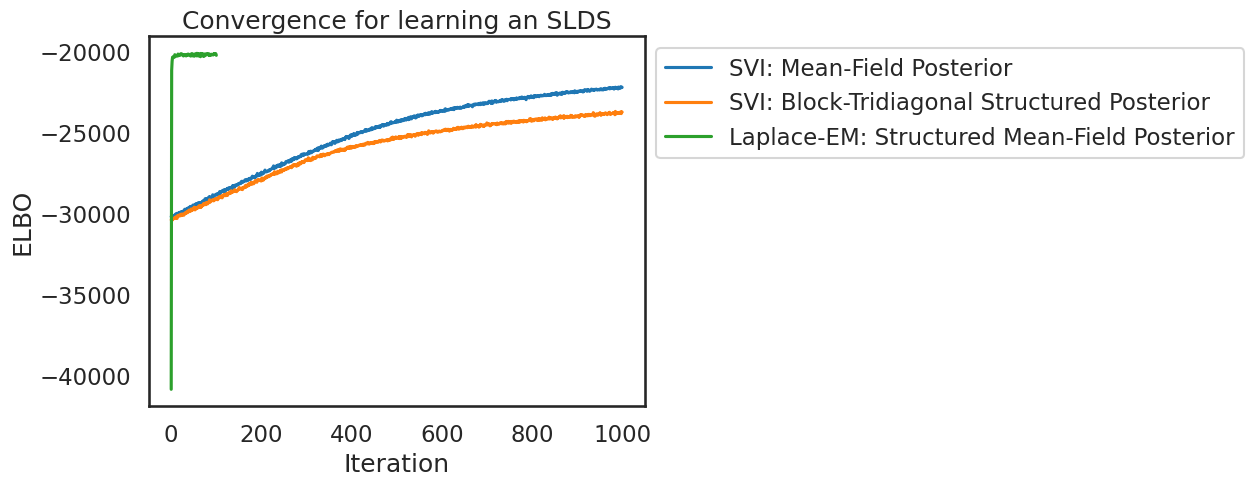

In [9]:
# Plot the ELBOs
plt.plot(q_mf_elbos, label="SVI: Mean-Field Posterior")
plt.plot(q_struct_elbos, label="SVI: Block-Tridiagonal Structured Posterior")
plt.plot(q_lem_elbos, label="Laplace-EM: Structured Mean-Field Posterior")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.title("Convergence for learning an SLDS")
plt.show()

### 3.2 Exercise: The Evidence Lower Bound (ELBO)
In the SLDS model (and even in the LDS case with non-Gaussian observations), we can't optimize the log-likelihood directly. Instead, we optimize a lower bound on the log likelihood called the Evidence Lower Bound (ELBO). 

We denote the parameters of the model as $\Theta$, which are considered fixed for the purposes of this exercise. Concretely, we need to find a lower bound on $\log(P(Y \mid \Theta))$ where $Y=[y_1,\ldots,y_T]$. Can you use Jensen's inequality to derive a lower bound on this likelihood?

## 4. Visualize True and Inferred Latent States
Below, we compare how well each fitting algorithm recovers the discrete latent states. We then inspect the true vs. inferred continuos latent states.

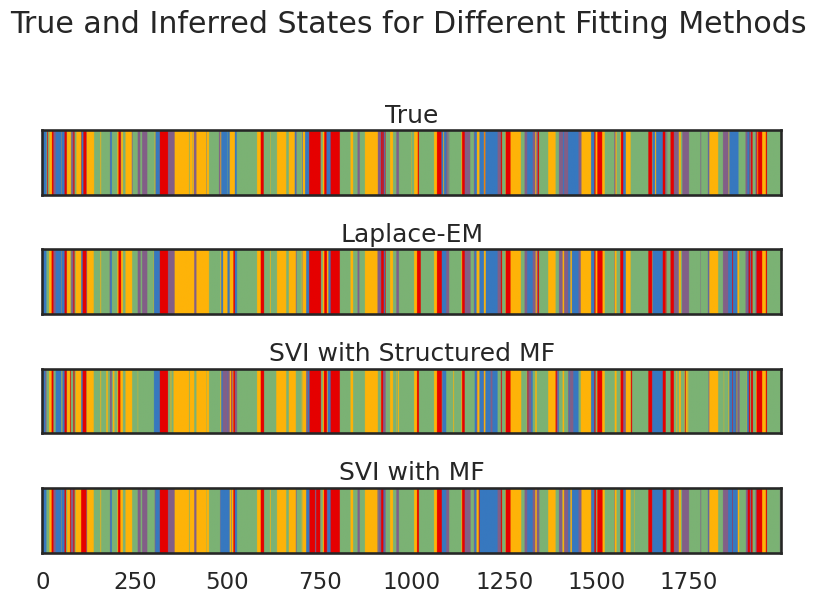

In [10]:
# Plot the true and inferred states
titles = ["True", "Laplace-EM", "SVI with Structured MF", "SVI with MF"]
states_list = [states_z, q_lem_z, q_struct_z, q_mf_z]
fig, axs = plt.subplots(4,1, figsize=(8,6))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_title(titles[i])
    if i < (len(axs) - 1):
        ax.set_xticks([])

plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()

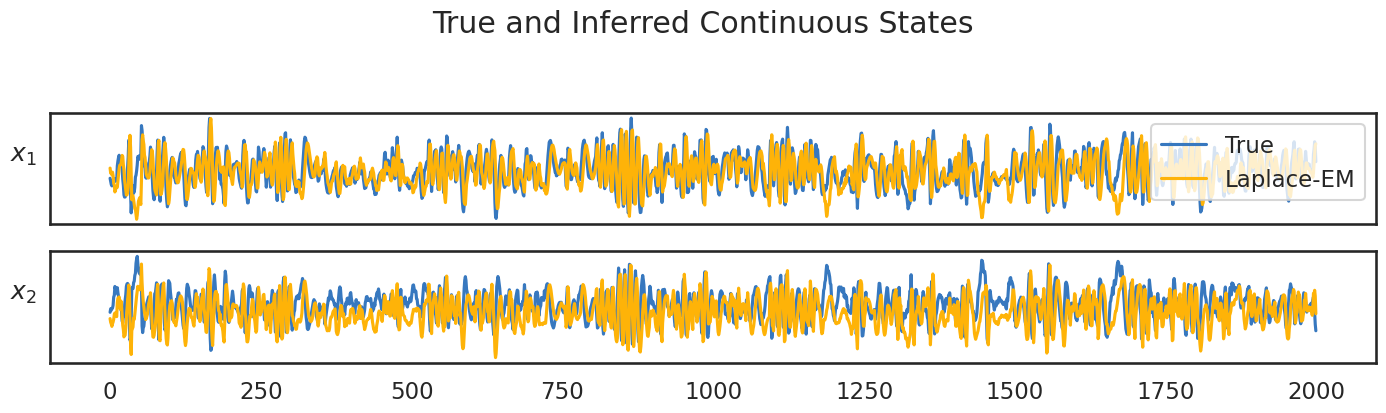

In [11]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(states_x[:,d] + 4 * d, '-', color=colors[0], label="True" if d==0 else None)
    ax.plot(q_lem_x[:,d] + 4 * d, '-', color=colors[2], label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("True and Inferred Continuous States", va="bottom")
plt.tight_layout()

### 4.2 Exercise: Fitting with fewer datapoints
From the above plots, it seems we were able to match the discrete states quite well using our learned model. Try reducing the number of time-bins used for fitting from 1000 to 500 or 100. At what point do we begin to fit badly?

## 5. Inference on unseen data
After learning a model from data, a common use-case is to compute the distribution over latent states given some new observations. For example, in the case of a simple LDS, we could use the Kalman Smoother to estimate the latent state trajectory given a set of observations. 

In the case of an SLDS (or Recurrent SLDS), the posterior over latent states can't be computed exactly. Instead, we need to live with a variational approximation to the true posterior. SSM allows us to compute this approximation using the `SLDS.approximate_posterior()` method. 

In the below example, we generate some new data from the true model. We then use the `approximate_posterior()` function to estimate the continuous and discrete states. 

  0%|          | 0/50 [00:00<?, ?it/s]

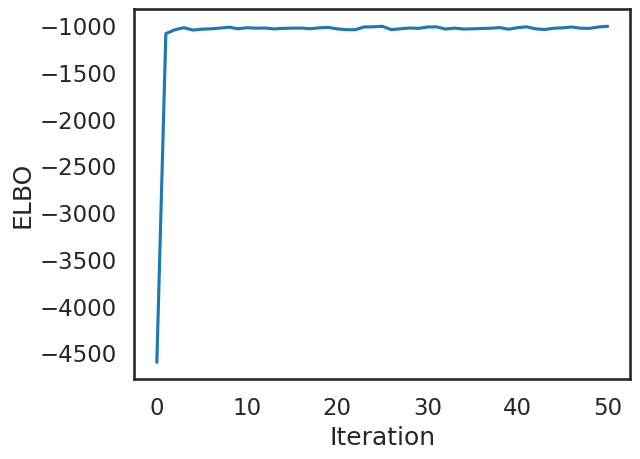

In [12]:
# Generate data which was not used for fitting
time_bins = 100
data_z, data_x, data = true_slds.sample(time_bins)

# Compute the approximate posterior over latent and continuous
# states for the new data under the current model parameters.
elbos, posterior = slds.approximate_posterior(data,
                                              method="laplace_em",
                                              variational_posterior="structured_meanfield",
                                              num_iters=50)

# Verify that the ELBO increases during fitting. We don't expect a substantial increase:
# we are updating the estimate of the latent states but we are not changing model params.
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

**Estimating Latent States**  
  
`posterior` is now an `ssm.variational.SLDSStructuredMeanFieldVariationalPosterior` object. Using this object, we can estimate the continuous and discrete states just like we did after calling the fit function.

In the below cell, we get the estimated continuous states as follows:
```python
posterior_x = posterior.mean_continuous_states[0]
```
This line uses the `mean_continuous_states` property of the posterior object, which returns a list, where each entry of the list corresponds to a single trial of data. Since we have only passed in a single trial the list will have length 1, and we take the first entry.

We then permute the discrete and continuous states to best match the ground truth. This is for aesthetic purposes when plotting. The following lines compute the best permutation which match the predicted states (`most_likely`) to the ground truth discrete states (`data_z`). We then permute the states of the SLDS accordingly:
```python

most_likely = slds.most_likely_states(posterior_x, data)
perm = find_permutation(data_z, most_likely)
slds.permute(perm)
z_est = slds.most_likely_states(posterior_x, data)

```



In [13]:
# Get the posterior mean of the continuous states
posterior_x = posterior.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
most_likely = slds.most_likely_states(posterior_x, data)
perm = find_permutation(data_z, most_likely)
slds.permute(perm)
z_est = slds.most_likely_states(posterior_x, data)

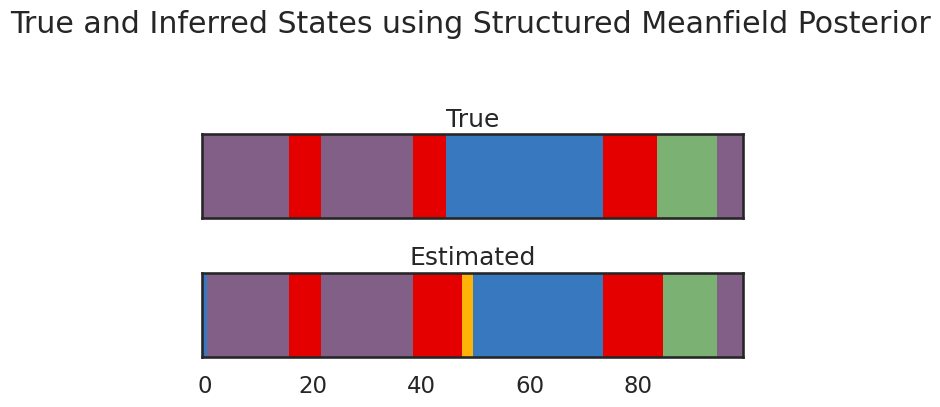

In [14]:
# Plot the true and inferred states
titles = ["True", "Estimated"]
states_list = [data_z, z_est]
fig, axs = plt.subplots(2,1, figsize=(6,4))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_title(titles[i])
    if i < (len(axs) - 1):
        ax.set_xticks([])

plt.suptitle("True and Inferred States using Structured Meanfield Posterior", va="baseline")
plt.tight_layout()

In [15]:
x_est = posterior.mean_continuous_states[0]

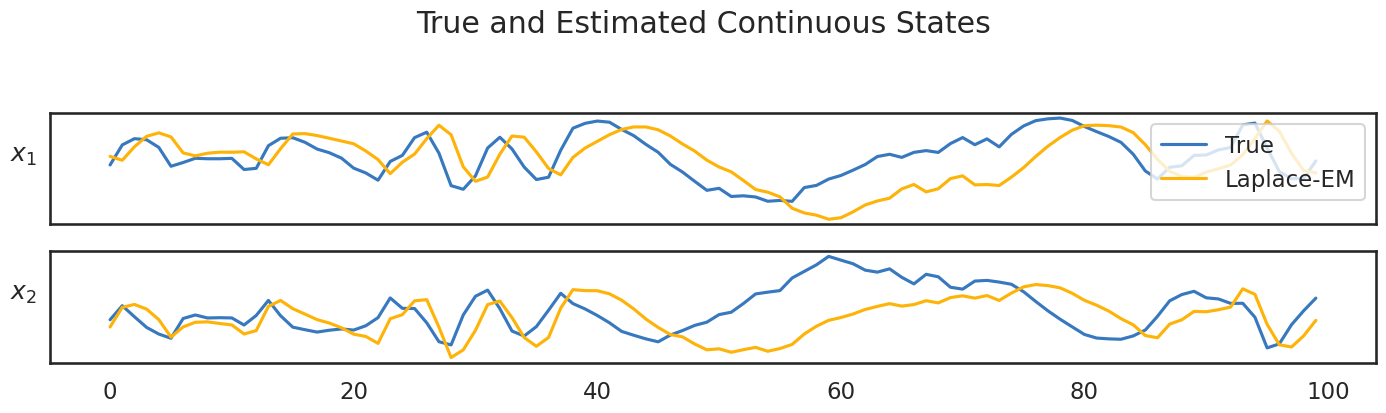

In [16]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(data_x[:,d] + 4 * d, '-', color=colors[0], label="True" if d==0 else None)
    ax.plot(x_est[:,d] + 4 * d, '-', color=colors[2], label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("True and Estimated Continuous States", va="bottom")
plt.tight_layout()